<a href="https://colab.research.google.com/github/ane-schow/oceanografia/blob/main/transporte_corrente_volume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install copernicusmarine
!pip install netCDF4
import copernicusmarine as cm
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import datetime
#cm.subset?

#Baixar dados

In [ ]:
cm.login()

Indicar o recorte dos dados

In [4]:
cm.subset(
    dataset_id = "cmems_mod_glo_phy_my_0.083deg_P1M-m",
    variables = ["uo"],
    minimum_longitude = -96.507293,
    maximum_longitude = -63.336000,
    minimum_latitude = -74.390233,
    maximum_latitude = -52.683000,
    start_datetime = "1993-01-01T00:00:00",
    end_datetime = "2024-10-21T00:00:00",
    minimum_depth = 0,
    maximum_depth = 5700,
    output_filename = "ccacur.nc",
    output_directory = "coper-data"
)

#cm login cria o path p credenciais

INFO - 2024-11-29T16:23:46Z - Dataset version was not specified, the latest one was selected: "202311"
INFO:copernicus_marine_root_logger:Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-11-29T16:23:46Z - Dataset part was not specified, the first one was selected: "default"
INFO:copernicus_marine_root_logger:Dataset part was not specified, the first one was selected: "default"
INFO - 2024-11-29T16:23:48Z - Service was not specified, the default one was selected: "arco-time-series"
INFO:copernicus_marine_root_logger:Service was not specified, the default one was selected: "arco-time-series"
WARNING - 2024-11-29T16:23:51Z - Some or all of your subset selection [1993-01-01 00:00:00, 2024-10-21 00:00:00] for the time dimension  exceed the dataset coordinates [1993-01-01 00:00:00, 2021-06-01 00:00:00]
INFO - 2024-11-29T16:23:51Z - Downloading using service arco-time-series...
INFO:copernicus_marine_root_logger:Downloading using service arco-time-series...

 Y


INFO - 2024-11-29T16:23:58Z - Writing to local storage. Please wait...
INFO:copernicus_marine_root_logger:Writing to local storage. Please wait...


  0%|          | 0/48752 [00:00<?, ?it/s]

INFO - 2024-11-29T16:38:44Z - Successfully downloaded to coper-data/ccacur.nc
INFO:copernicus_marine_root_logger:Successfully downloaded to coper-data/ccacur.nc


PosixPath('coper-data/ccacur.nc')

#Abrir dados

In [5]:
fn = '/content/coper-data/ccacur.nc'
df = xr.open_dataset(fn)
u0 = df['uo']
print(u0.shape, u0.dims, u0.attrs)

(342, 49, 260, 398) ('time', 'depth', 'latitude', 'longitude') {'cell_methods': 'area: mean', 'long_name': 'Eastward velocity', 'standard_name': 'eastward_sea_water_velocity', 'unit_long': 'Meters per second', 'units': 'm s-1', 'valid_max': 4700, 'valid_min': -3800}


Ver último recorte do dado

In [6]:
print(u0.time[-1].values)

2021-06-01T00:00:00.000000000


#Definindo a função que calcula o transporte

In [8]:
R = 6371000
sv_factor = 1e6

def transporte_corrente(u, p, lat):

  delta_lat = np.diff(lat)
  delta_lat_rad = np.radians(delta_lat)
  dist_lat = (R * delta_lat_rad)

  delta_p = np.diff(p)

  u = u.transpose().squeeze()
  c = u[:-1, :-1]
  masc = ~np.isnan(c)
  area_cel = np.outer(dist_lat, delta_p)
  transporte_cel = c * area_cel * masc
  transporte_por_lat = np.nansum(transporte_cel)
  transporte_pl = transporte_por_lat / sv_factor

  return transporte_pl

#Manipulando os dados

In [9]:
array_transportes = np.full((len(u0['time']), len(u0['longitude'])), np.nan)

for j in range(len(u0['time'])):
    for i in range(len(u0['longitude'])):
        u = u0.isel(time=j, longitude=i).squeeze()
        p = u0['depth']
        lat = u0['latitude']

        transporte = transporte_corrente(u, p, lat)
        array_transportes[j, i] = transporte

da_transportes = xr.DataArray(array_transportes,
                                 dims=['time', 'longitude'],
                                 coords={'time': u0['time'],'longitude': u0['longitude']})
print(da_transportes.attrs)

In [25]:
transp_em_tempos = np.mean(da_transportes, axis=1)
tempos = range(len(da_transportes['time']))
print(da_transportes.shape, transp_em_tempos.ndim)
print(tempos)

(342, 398) 1
range(0, 342)


#Plotando o gráfico


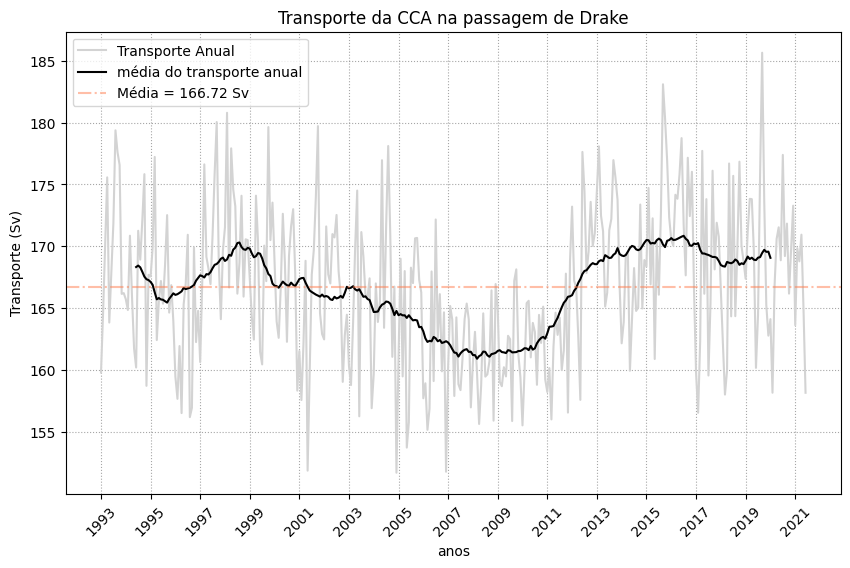

In [22]:
media_transporte = np.mean(transp_em_tempos)
transp_em_tempos_smooth = pd.Series(transp_em_tempos).rolling(window=35, center=True).mean()
plt.figure(figsize=(10, 6))
plt.plot(tempos, transp_em_tempos, linestyle='-', color='lightgray', label='Transporte Anual')
plt.plot(tempos, transp_em_tempos_smooth, linestyle='-', color='k', label='média do transporte anual')
plt.xticks(ticks=range(0, len(tempos), 24), labels=range(1993, 1993 + len(range(0, len(tempos), 12)),2), rotation=45)
plt.axhline(y=media_transporte, color='coral', linestyle='-.', label=f"Média = {media_transporte:.2f} Sv", alpha = 0.5)
plt.xlabel('anos')
plt.ylabel('Transporte (Sv)')
plt.title('Transporte da CCA na passagem de Drake')
plt.grid(color='gray',alpha=0.7, linestyle=':')
plt.legend()
plt.show()

In [29]:
grupos_anuais = transp_em_tempos.groupby('time.year')
grupo2019 = grupos_anuais[2019]
max = np.max(grupo2019)
print(max)

time_values = np.where(transp_em_tempos.values >= 180)
print('Esses são os indices em que o transporte é maior que 180 SV: ', time_values)

tempo_onde = transp_em_tempos.time[time_values]
print('Esses são os indices em que o transporte é maior que 180 SV: ', tempo_onde)

<xarray.DataArray ()> Size: 8B
array(185.64150104)
Esses são os indices em que o transporte é maior que 180 SV:  (array([ 56,  61, 272, 273, 320]),)
Esses são os indices em que o transporte é maior que 180 SV:  <xarray.DataArray 'time' (time: 5)> Size: 40B
array(['1997-09-01T00:00:00.000000000', '1998-02-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2019-09-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 40B 1997-09-01 1998-02-01 ... 2019-09-01
Attributes:
    valid_min:  376944
    valid_max:  626016
